In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Libraries

In [ ]:
os.environ["KERAS_BACKEND"] = "jax"

import keras_nlp
import keras
import tensorflow as tf

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.express as px
import ast
import math
from sklearn.model_selection import StratifiedKFold

In [ ]:
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasNLP:", keras_nlp.__version__)

定义一个 CFG 配置类，主要用于存储 训练和模型超参数

In [ ]:
class CFG:
    seed = 42
    preset = "deberta_v3_extra_small_en" # name of pretrained models
    sequence_length = 512 # input sequence length
    epochs = 5 # 训练的 总轮数
    batch_size = 16
    scheduler = 'cosine' # learning rate scheduler
    label2name = {0:'winner_model_a', 1:'winner_model_b', 2:'winner_tie'}
    name2label = {v: k for k, v in label2name.items()}
    class_labels = list(label2name.keys())
    class_names = list(label2name.values())

In [ ]:
keras.utils.set_random_seed(CFG.seed)

Mixed Precision

In [ ]:
keras.mixed_precision.set_global_policy("mixed_float16")

In [ ]:
BASE_PATH = '/kaggle/input/llm-classification-finetuning'

In [ ]:
# load train data
df = pd.read_csv(f'{BASE_PATH}/train.csv')

df

In [ ]:
len(df)

In [ ]:
df.prompt[0]

In [ ]:
df.prompt[1]

In [ ]:
ast.literal_eval(df.prompt[1])

In [ ]:
ast.literal_eval(df.response_a[1])

In [ ]:
ast.literal_eval(df.response_b[1])

In [ ]:
df.prompt.map(lambda x: ast.literal_eval(x)[0])

In [ ]:
# take the first prompt and its associated response
df["prompt"] = df.prompt.map(lambda x: ast.literal_eval(x)[0])
df["response_a"] = df.response_a.map(lambda x: ast.literal_eval(x.replace("null", "''"))[0])
df["response_b"] = df.response_b.map(lambda x: ast.literal_eval(x.replace("null", "''"))[0])

In [ ]:
df.prompt[1]

In [ ]:
df.response_a[1]

In [ ]:
df.response_b[1]

In [ ]:
# label conversion
df["class_name"] = df[["winner_model_a", "winner_model_b", "winner_tie"]].idxmax(axis=1) # 在 每一行 查找 值最大的列名
df["class_label"] = df.class_name.map(CFG.name2label)
df.head()

In [ ]:
# load test data
test_df = pd.read_csv(f'{BASE_PATH}/test.csv')

test_df

In [ ]:
# take the first prompt and its associated response
test_df["prompt"] = test_df.prompt.map(lambda x: ast.literal_eval(x)[0])
test_df["response_a"] = test_df.response_a.map(lambda x: ast.literal_eval(x.replace("null", "''"))[0])
test_df["response_b"] = test_df.response_b.map(lambda x: ast.literal_eval(x.replace("null", "''"))[0])

test_df.head()

# Contextualize Response with Prompt

In [ ]:
# Define a function to create options based on the prompt and choices
def make_pairs(row):
    row["encode_fail"] = False
    try:
        prompt = row.prompt.encode("utf-8").decode("utf-8")
    except:
        prompt = ""
        row["encode_fail"] = True

    try:
        response_a = row.response_a.encode("utf-8").decode("utf-8")
    except:
        response_a = ""
        row["encode_fail"] = True

    try:
        response_b = row.response_b.encode("utf-8").decode("utf-8")
    except:
        response_b = ""
        row["encode_fail"] = True

    row["options"] = [
        f"Prompt: {prompt}\n\nResponse: {response_a}",
        f"Prompt: {prompt}\n\nResponse: {response_b}"
    ]
    return row

In [ ]:
df = df.apply(make_pairs, axis=1)
display(df.head(2))

In [ ]:
df.options[1]

In [ ]:
test_df = test_df.apply(make_pairs, axis=1)
display(test_df.head(2))

In [ ]:
test_df.options[0]

## Encoding fail statistics

In [ ]:
df.encode_fail.value_counts(normalize=False)

normalize=False（默认值）表示 返回绝对计数（即每个值出现的具体次数，而不是比例）。

In [ ]:
df.encode_fail.value_counts(normalize=True)

Only 1% of the samples failed to be encoded. Considering empty string for this small portion of the data will not have mush impact on our training and inference.

# EDA

In [ ]:
model_df = pd.concat([df.model_a, df.model_b])
model_df

In [ ]:
counts = model_df.value_counts().reset_index()
counts

In [ ]:
counts.columns = ['LLM', 'Count']
counts

In [ ]:
fig = px.bar(counts, x='LLM', y='Count', title='Distribution of LLMs', color='Count',
            color_continuous_scale='viridis')
# color='Count'：柱状图的颜色根据 Count 值 变化（即 LLM 出现次数）。
# 使用 Viridis 颜色映射（从紫色到黄色的渐变色）。

fig.update_layout(xaxis_tickangle=-45)

fig.show()

## Winning distribution

In [ ]:
counts = df['class_name'].value_counts().reset_index()
counts

In [ ]:
counts.columns = ['Winner', 'Win Count']

fig = px.bar(counts, x='Winner', y='Win Count', title='Winner distribution for Train Data',
            labels={'Winner': 'Winner', 'Win Count': 'Win Count'},
            color='Winner', color_continuous_scale='viridis')

# labels={'Winner': 'Winner', 'Win Count': 'Win Count'}：自定义 x 轴和 y 轴的标签，让它们更清晰易读。

fig.update_layout(xaxis_title='Winner', yaxis_title='Win Count')
fig.show()

# Data Split

In [ ]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size=0.2, stratify=df["class_label"])

In [ ]:
train_df.head()

# Preprocessing

In [ ]:
preprocessor = keras_nlp.models.DebertaV3Preprocessor.from_preset(
    preset=CFG.preset,
    sequence_length = CFG.sequence_length
)

In [ ]:
outs = preprocessor(df.options.iloc[0])

for k, v in outs.items():
    print(k, ": ", v.shape)

In [ ]:
df.options[0]

In [ ]:
def preprocess_fn(text, label=None):
    text = preprocessor(text)
    return (text, label) if label is not None else text

# DataLoader

In [ ]:
def build_dataset(texts, labels=None, batch_size=32, cache=True, shuffle=1024):
    # 让 TensorFlow 自动选择最佳并行化设置，提高数据加载速度
    AUTO = tf.data.AUTOTUNE
    
    # 将 labels 转换为 one-hot 编码（3 分类问题）
    slices = (texts, ) if labels is None else (texts, keras.utils.to_categorical(labels, num_classes=3))
    
    # 将 texts 和 labels 转换为 tf.data.Dataset 对象，使其能被深度学习模型高效加载。
    ds = tf.data.Dataset.from_tensor_slices(slices)
    
    # 如果 cache=True，数据集会存入 RAM，加快数据读取速度
    ds = ds.cache() if cache else ds
    ds = ds.map(preprocess_fn, num_parallel_calls=AUTO)
    
    opt = tf.data.Options()
    if shuffle:
        # 如果 shuffle=True，随机打乱数据
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt.experimental_deterministic = False
    ds = ds.with_options(opt)

    # 将数据 按批次 处理，提高训练效率。
    # 不丢弃最后一个 batch（即使样本数不足 batch_size）
    ds = ds.batch(batch_size, drop_remainder=False)

    # prefetch(AUTO)：提前加载数据，提高 GPU 计算效率
    ds = ds.prefetch(AUTO)
    return ds
    

# Build Train/Valid DataLoader

In [ ]:
# Train
train_texts = train_df.options.tolist()
train_labels = train_df.class_label.tolist()

In [ ]:
train_texts[0]

In [ ]:
train_labels[0]

In [ ]:
train_ds = build_dataset(train_texts, train_labels, batch_size=CFG.batch_size, shuffle=True)

In [ ]:
# Valid
valid_texts = valid_df.options.tolist()
valid_labels = valid_df.class_label.tolist()
valid_ds = build_dataset(valid_texts, valid_labels, batch_size=CFG.batch_size, shuffle=False)

In [ ]:
for data in valid_ds.take(1):  # 取出第一个 batch
    print(data)

# 学习率调度器 (Learning Rate Scheduler)

1. Step Decay (阶梯衰减)：在 固定的训练 epoch 后，学习率 以阶梯方式降低。例如，在 10、20、30 轮时减少学习率，如 lr = lr * 0.1。
2. Cosine Decay (余弦衰减)：采用 余弦函数 (cosine curve) 平滑降低学习率，常用于 余弦退火 (Cosine Annealing)。适用于长时间训练，避免学习率突然下降导致的震荡。
3. Exponential Decay (指数衰减)：按照公式 lr = lr * decay_rate^epoch 指数级减少 学习率。适用于深度神经网络，尤其是大规模数据集。

In [ ]:
def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    # 初始学习率 (最低起点)，最大学习率 (取决于 batch_size)，最低学习率 (不会低于此值)。
    lr_start, lr_max, lr_min = 1.0e-6, 0.6e-6*batch_size, 1e-6
    # 前 2 个 epoch 线性增长 到 lr_max (warm-up 阶段)，保持学习率不变的 epoch (这里是 0)，指数衰减的 衰减因子
    lr_ramp_ep, lr_sus_ep, lr_decay = 2, 0, 0.8

    def lrfn(epoch):
        # 学习率从 lr_start 线性增加到 lr_max，以稳定模型的训练
        if epoch < lr_ramp_ep: 
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        # 维持最大学习率
        elif epoch < lr_ramp_ep + lr_sus_ep: 
            lr = lr_max
        # 指数函数形式降低学习率，越往后衰减越慢
        elif mode == 'exp': 
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        # 每隔 2 个 epoch，学习率 乘以 lr_decay=0.8
        elif mode == 'step': 
            lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        # 采用 余弦函数 平滑降低学习率
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch');plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()
        
    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)

In [ ]:
lr_cb = get_lr_callback(CFG.batch_size, plot=True)

# Model Checkpointing

在 Keras 训练过程中自动保存最佳模型的权重

In [ ]:
ckpt_cb = keras.callbacks.ModelCheckpoint(
    f'best_model.weights.h5',
    monitor='val_log_loss',
    save_best_only = True, # 仅保存最好的模型
    save_weights_only = True,
    mode = 'min'                                        
)

# Metric

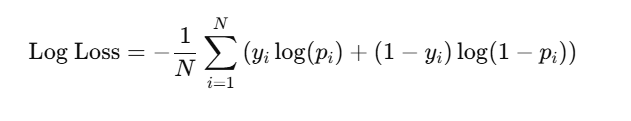

In [ ]:
log_loss = keras.metrics.CategoricalCrossentropy(name="log_loss")

当真实类别y=1时，损失函数变为-log(p)。
如果 p 越接近 1，损失越小。
如果 p 接近 0，损失会变大（趋向无穷大）。

In [ ]:
# 定义 p 的取值（避免 log(0)）
p = np.linspace(0.01, 1, 100)
loss = -np.log(p)

# 绘制曲线
plt.figure(figsize=(8, 5))
plt.plot(p, loss, label=r'$-\log(p)$', color='b')
plt.xlabel("Predicted Probability (p)")
plt.ylabel("Loss")
plt.title("Negative Log Function: $-\log(p)$")
plt.grid()
plt.legend()
plt.show()

当真实类别y=0，损失函数变为：-log(1-p)。
如果p越接近0，损失越小。
如果p接近1，损失会变大。

In [ ]:
# 定义 p 的取值（避免 log(0)）
p = np.linspace(0, 0.99, 100)
loss = -np.log(1 - p)

# 绘制曲线
plt.figure(figsize=(8, 5))
plt.plot(p, loss, label=r'$-\log(1 - p)$', color='r')
plt.xlabel("Predicted Probability (p)")
plt.ylabel("Loss")
plt.title("Negative Log Function: $-\log(1 - p)$")
plt.grid()
plt.legend()
plt.show()

# Modeling

In [ ]:
# Define input layers
# token_ids: 表示文本的 token 编码。
# padding_mask: 指示哪些 token 是有效的（1）或填充的（0）
inputs = {
    "token_ids": keras.Input(shape=(2, None), dtype=tf.int32, name="token_ids"),
    "padding_mask": keras.Input(shape=(2, None), dtype=tf.int32, name="padding_mask"),
}

# Create a DebertaV3Classifier backbone
# 加载 DeBERTaV3 作为特征提取骨干网络（Backbone）
# 作用: 负责将 token 序列转换为 语义嵌入表示（embeddings）
backbone = keras_nlp.models.DebertaV3Backbone.from_preset(
    CFG.preset,
)

# inputs 原本形状为 (batch_size, 2, sequence_length)，其中 2 代表 两个 P+R 组合
# 使用相同的 DeBERTaV3 模型 共享权重
# Compute embeddings for first response: (P + R_A) using backbone
response_a = {k: v[:, 0, :] for k, v in inputs.items()}
embed_a = backbone(response_a)

# Compute embeddings for second response: (P + R_B) using the same backbone
response_b = {k: v[:, 1, :] for k, v in inputs.items()}
embed_b = backbone(response_b)

# Compute final output
embeds = keras.layers.Concatenate(axis=-1)([embed_a, embed_b]) # 沿着最后一维拼接两个嵌入
embeds = keras.layers.GlobalAveragePooling1D()(embeds) # 对拼接后的嵌入进行全局平均池化，以减少维度并获得固定长度的向量。

# 输出 3 维，分别对应：
# winner_model_a（P + R_A 更佳）
# winner_model_b（P + R_B 更佳）
# draw（两个响应相等）
outputs = keras.layers.Dense(3, activation="softmax", name="classifier")(embeds)
model = keras.Model(inputs, outputs)

# Compile the model with optimizer, loss and metrics
model.compile(
    optimizer=keras.optimizers.Adam(5e-6), # Adam 优化器：学习率 5e-6（较小，适用于预训练模型微调）
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.02), # label_smoothing=0.02 用于 减少过拟合，防止模型对某些类别过度自信
    metrics=[
        log_loss,
        keras.metrics.CategoricalAccuracy(name="accuracy")
    ]
)

In [ ]:
model.summary()

In [ ]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

# Training

In [ ]:
history = model.fit(
    train_ds,
    epochs = CFG.epochs, # 1 个 epoch = 完整训练数据集被模型遍历 1 次。
    validation_data = valid_ds, # 在 每个 epoch 结束后，模型在 valid_ds 进行 评估，检查性能
    callbacks=[lr_cb, ckpt_cb]
)

# deberta_v3_small_en
Epoch 1/3
2874/2874 ━━━━━━━━━━━━━━━━━━━━ 3480s 1s/step - accuracy: 0.3996 - log_loss: 1.0944 - loss: 1.0954 - val_accuracy: 0.4572 - val_log_loss: 1.0450 - val_loss: 1.0471 - learning_rate: 1.0000e-06

Epoch 2/3
2874/2874 ━━━━━━━━━━━━━━━━━━━━ 3419s 1s/step - accuracy: 0.4461 - log_loss: 1.0547 - loss: 1.0570 - val_accuracy: 0.4799 - val_log_loss: 1.0249 - val_loss: 1.0280 - learning_rate: 5.3000e-06

Epoch 3/3
2874/2874 ━━━━━━━━━━━━━━━━━━━━ 3362s 1s/step - accuracy: 0.4765 - log_loss: 1.0257 - loss: 1.0293 - val_accuracy: 0.4746 - val_log_loss: 1.0269 - val_loss: 1.0306 - learning_rate: 9.6000e-06

# deberta_v3_extra_small_en
Epoch 1/3
2874/2874 ━━━━━━━━━━━━━━━━━━━━ 2689s 921ms/step - accuracy: 0.3887 - log_loss: 1.1498 - loss: 1.1508 - val_accuracy: 0.4382 - val_log_loss: 1.0643 - val_loss: 1.0662 - learning_rate: 1.0000e-06

Epoch 2/3
2874/2874 ━━━━━━━━━━━━━━━━━━━━ 2586s 887ms/step - accuracy: 0.4431 - log_loss: 1.0635 - loss: 1.0655 - val_accuracy: 0.4664 - val_log_loss: 1.0417 - val_loss: 1.0444 - learning_rate: 5.3000e-06

Epoch 3/3
2874/2874 ━━━━━━━━━━━━━━━━━━━━ 2540s 884ms/step - accuracy: 0.4654 - log_loss: 1.0397 - loss: 1.0425 - val_accuracy: 0.4717 - val_log_loss: 1.0326 - val_loss: 1.0357 - learning_rate: 9.6000e-06

# Load Best Model

In [ ]:
model.load_weights('/kaggle/working/best_model.weights.h5')

# Prediction

In [ ]:
# Build test dataset
test_texts = test_df.options.tolist()
test_ds = build_dataset(
    test_texts,
    batch_size=min(len(test_df), CFG.batch_size),
    shuffle=False
)

In [ ]:
# Make predictions using the trained model on test data
test_preds = model.predict(test_ds, verbose=1)

# 5-Fold Cross-Validation and Ensemble

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 9002724144 bytes.

In [ ]:
# # Define constants 
# NUM_FOLDS = 5

# # Prepare Stratified K-Fold
# skf = StratifiedKFold(n_splits = NUM_FOLDS, shuffle=True, random_state=CFG.seed)

# train_data = df.options
# train_labels = df.class_label

# # Store models and out-of-fold predictions
# models = []
# oof_predictions = np.zeros((len(train_data), 3))

# for fold, (train_idx, val_idx) in enumerate(skf.split(train_data, train_labels)):
#     print(f"Training Fold {fold+1}/{NUM_FOLDS}")

#     # Create train and validation datasets
#     X_train, X_val = train_data.iloc[train_idx].tolist(), train_data.iloc[val_idx].tolist()
#     y_train, y_val = train_labels.iloc[train_idx].tolist(), train_labels.iloc[val_idx].tolist()

#     train_ds = build_dataset(X_train, y_train, batch_size=CFG.batch_size, shuffle=True)
#     valid_ds = build_dataset(X_val, y_val, batch_size=CFG.batch_size, shuffle=False)

#     # Define inputs
#     inputs = {
#         "token_ids": keras.Input(shape=(2, None), dtype=tf.int32, name="token_ids"),
#         "padding_mask": keras.Input(shape=(2, None), dtype=tf.int32, name="padding_mask"),
#     }

#     # Create DeBERTaV3 backbone
#     backbone = keras_nlp.models.DebertaV3Backbone.from_preset(
#         CFG.preset,
#     )

#     # Compute embeddings for first response: (P + R_A) using backbone
#     response_a = {k: v[:, 0, :] for k, v in inputs.items()}
#     embed_a = backbone(response_a)

#     # Compute embeddings for second response: (P + R_B) using the same backbone
#     response_b = {k: v[:, 1, :] for k, v in inputs.items()}
#     embed_b = backbone(response_b)

#     # Concatenate embeddings and apply pooling
#     embeds = keras.layers.Concatenate(axis=-1)([embed_a, embed_b]) # 沿着最后一维拼接两个嵌入
#     embeds = keras.layers.GlobalAveragePooling1D()(embeds) # 对拼接后的嵌入进行全局平均池化，以减少维度并获得固定长度的向量。
#     outputs = keras.layers.Dense(3, activation="softmax", name="classifier")(embeds)

#     # Create model
#     model = keras.Model(inputs, outputs)

#     # Compile the model with optimizer, loss and metrics
#     model.compile(
#         optimizer=keras.optimizers.Adam(5e-6), # Adam 优化器：学习率 5e-6（较小，适用于预训练模型微调）
#         loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.02), # label_smoothing=0.02 用于 减少过拟合，防止模型对某些类别过度自信
#         metrics=[
#             log_loss,
#             keras.metrics.CategoricalAccuracy(name="accuracy")
#         ]
#     )

#     # Define callbacks
#     ckpt_cb = keras.callbacks.ModelCheckpoint(
#         f'best_model_fold{fold+1}.weights.h5',
#         monitor='val_log_loss',
#         save_best_only = True, # 仅保存最好的模型
#         save_weights_only = True,
#         mode = 'min'                                        
#     )

#     # Train model
#     history = model.fit(
#         train_ds,
#         epochs = CFG.epochs, # 1 个 epoch = 完整训练数据集被模型遍历 1 次。
#         validation_data = valid_ds, # 在 每个 epoch 结束后，模型在 valid_ds 进行 评估，检查性能
#         callbacks=[lr_cb, ckpt_cb]
#     )

#     # Store model
#     models.append(model)
    
#     # Out-of-fold predictions
#     oof_predictions[val_idx] = model.predict(valid_ds)


In [ ]:
# # Save all models for later ensembling
# for i, model in enumerate(models):
#     model.save_weights(f"deberta_model_fold{i+1}.h5")

In [ ]:
# # Build test dataset
# test_texts = test_df.options.tolist()
# test_ds = build_dataset(
#     test_texts,
#     batch_size=min(len(test_df), CFG.batch_size),
#     shuffle=False
# )

In [ ]:
# def predict_with_ensemble(models, test_ds):
#     predictions = np.zeros((len(test_ds), 3))
#     for model in models:
#         predictions += model.predict(test_ds) / len(models)
#     return predictions

# # Get final predictions using ensemble
# test_preds = predict_with_ensemble(models, test_ds)

# Submission"

In [ ]:
CFG.class_names

In [ ]:
test_preds

In [ ]:
sub_df = test_df[["id"]].copy()
sub_df[CFG.class_names] = test_preds.tolist()
sub_df.to_csv("submission.csv", index=False)
sub_df